In [1]:
import numpy as np
from matplotlib import pyplot as plt
from tqdm import tqdm

from floquet_analysis.transmon_floquet_simulator import TransmonFloquetSimulator
from floquet_analysis.transmon_resonator_fitter import TransmonResonatorFitter
from joblib import Parallel, delayed

In [2]:
# Measured frequencies
f01_meas = 3.845965050
f12_meas = 3.602264855

fr0_meas = 6.065852884
fr1_meas = 6.064931745
fr2_meas = 6.064094073

fitter = TransmonResonatorFitter(f01_meas, f12_meas, fr0_meas, fr1_meas, fr2_meas)

fitted_parameters = fitter.fit_parameters()

fitter.print_results()

# Examples for later usage
EJ_fitted, EC_fitted, fr_fitted, g_fitted = fitter.fitted_params

fitted_frequencies_array = fitter.fitted_frequencies

Initial guess for [EJ, EC, fr, g]: [8.578861527050124, 0.24370019500000017, 6.0653923145, np.float64(0.09103399089132334)]

--- Fitting Results ---
Fitted EJ: 9.8266 GHz
Fitted EC: 0.2106 GHz
Fitted Resonator Freq (bare, f_r): 6.0650 GHz
Fitted Coupling Strength (g): 0.1017 GHz

Fitted Frequencies (from model with fitted parameters):
  Qubit f01: 3.8460 GHz
  Qubit f12: 3.6023 GHz
  Resonator freq @ Qubit |0>: 6.0650 GHz
  Resonator freq @ Qubit |1>: 6.0650 GHz
  Resonator freq @ Qubit |2>: 6.0650 GHz

Measured Frequencies (input data):
  Qubit f01: 3.8460 GHz
  Qubit f12: 3.6023 GHz
  Resonator freq @ Qubit |0>: 6.0659 GHz
  Resonator freq @ Qubit |1>: 6.0649 GHz
  Resonator freq @ Qubit |2>: 6.0641 GHz

Total Squared Error: 1.55e-06


Avg Excitation: 100%|██████████| 151/151 [00:06<00:00, 22.48it/s]


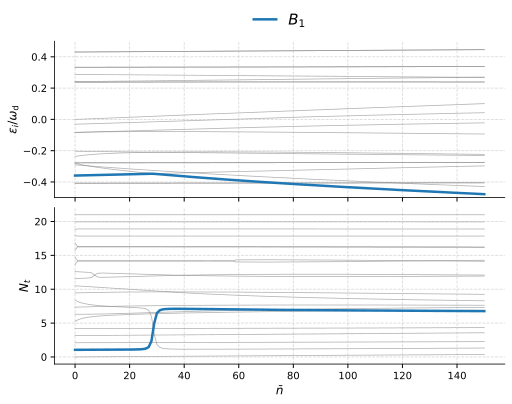

n_r_critical 28


In [3]:
# Define parameters for the Floquet simulation
Ec = EC_fitted * 2 * np.pi
EjEc = EJ_fitted / EC_fitted
N = 10  # Charge basis truncation
w_d = 6 * 2 * np.pi  # GHz (Drive frequency)

# Define the range of resonator photon numbers
n_r_list_sim = np.linspace(0, 70, 71)
g_strength_sim = g_fitted * 2 * np.pi  # Coupling strength in GHz

# Initialize the simulator
simulator = TransmonFloquetSimulator(Ec, EjEc, N, w_d, g_strength_sim, n_r_list_sim, ng=0)

result = simulator.find_n_r_critical(branch_index=1)
# result = simulator.find_minmax_n_r_critical(branch_index=1, ng=np.linspace(0, 0.5, 50))
print("n_r_critical", result)

Finding n_r_critical for different and resonator frequencies: 100%|██████████| 50/50 [52:21<00:00, 62.83s/it]


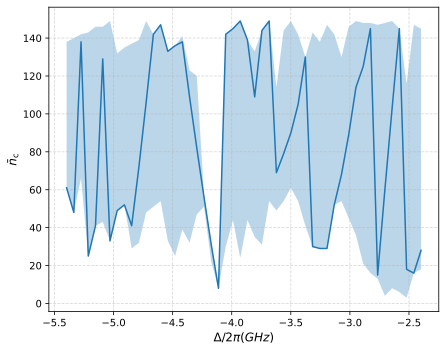

In [7]:
ng = np.linspace(0, 0.5, 51)
w_d = np.linspace(6, 9, 100) * 2 * np.pi

state_to_inspect = 1


def func_to_parallelize(ng_val, w_d_val):
    simulator_tmp = TransmonFloquetSimulator(Ec, EjEc, N, w_d_val, g_strength_sim, n_r_list_sim, ng_val)

    n_critical_for_this_ng = simulator_tmp.find_n_r_critical(state_to_inspect, plot=False)
    state_energy = simulator_tmp.bare_eigenenergies[state_to_inspect+1]-simulator_tmp.bare_eigenenergies[state_to_inspect]
    return n_critical_for_this_ng, (state_energy - w_d_val) / (2 * np.pi)

all_results = []
all_filtered_results = []
result_min = []
result_max = []
result_ng0 = []
for w_d_val in tqdm(w_d, desc="Finding n_r_critical for different and resonator frequencies"):
    result = Parallel(n_jobs=-1)(
        delayed(func_to_parallelize)(ng_val, w_d_val)
        for ng_val in ng
    )
    # remove nans
    result_filtered = [sublist for sublist in result if not any(np.isnan(item) for item in sublist)]

    all_results.append(result)
    all_filtered_results.append(result_filtered)

    result_ng0 += [result_filtered[0]]
    result_min += [min(result_filtered, key=lambda x: x[0])]
    result_max += [max(result_filtered, key=lambda x: x[0])]

result_min = np.array(result_min)
result_max = np.array(result_max)
result_ng0 = np.array(result_ng0)

n_critical_min = result_min[:, 0]
n_critical_max = result_max[:, 0]
n_critical_ng0 = result_ng0[:, 0]
delta_ng0 = result_ng0[:, 1]

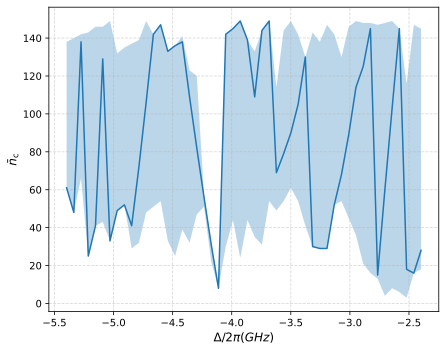

In [11]:
fig, axs = plt.subplots(1, 1, figsize=(7, 5.5), sharex=True, dpi=300)

axs.set_xlabel(r'$\Delta/2\pi (GHz)$', fontsize=12)
axs.set_ylabel(r'$\bar{n}_\text{c}$', fontsize=12)
axs.grid(True, linestyle='--', alpha=0.5, zorder=0)

axs.plot(delta_ng0, n_critical_ng0)
axs.fill_between(result_ng0[:, 1], n_critical_min, n_critical_max ,alpha=0.3)
plt.savefig("detuning_nc_with_ng.png")

plt.show()

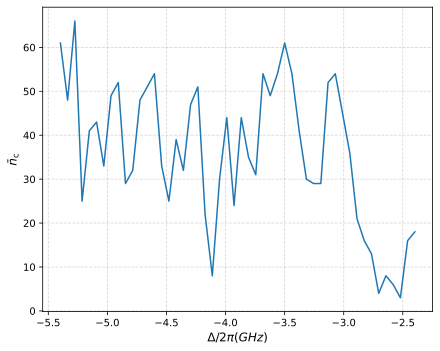

In [12]:
fig, axs = plt.subplots(1, 1, figsize=(7, 5.5), sharex=True, dpi=300)

axs.set_xlabel(r'$\Delta/2\pi (GHz)$', fontsize=12)
axs.set_ylabel(r'$\bar{n}_\text{c}$', fontsize=12)
axs.grid(True, linestyle='--', alpha=0.5, zorder=0)

axs.plot(delta_ng0, n_critical_min)
plt.savefig("detuning_nc_with_ng_min.png")

plt.show()

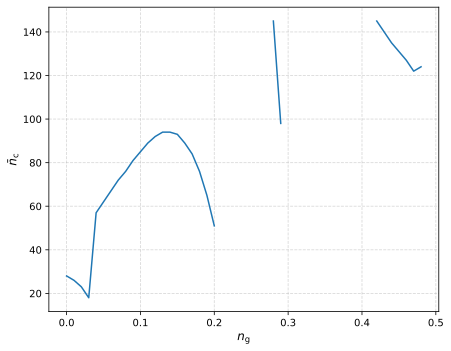

In [5]:
fig, axs = plt.subplots(1, 1, figsize=(7, 5.5), sharex=True, dpi=300)

axs.set_xlabel(r'$n_\text{g}$', fontsize=12)
axs.set_ylabel(r'$\bar{n}_\text{c}$', fontsize=12)
axs.grid(True, linestyle='--', alpha=0.5, zorder=0)
print()
axs.plot(ng, np.array(all_results[0])[:,0])

plt.show()

In [6]:
all_results[0]

[(28, np.float64(-2.397735819402644)),
 (26, np.float64(-2.3977353678208915)),
 (23, np.float64(-2.397734014855749)),
 (18, np.float64(-2.3977317658405815)),
 (57, np.float64(-2.3977286296410436)),
 (62, np.float64(-2.397724618620259)),
 (67, np.float64(-2.397719748590242)),
 (72, np.float64(-2.397714038749775)),
 (76, np.float64(-2.3977075116089726)),
 (81, np.float64(-2.397700192900824)),
 (85, np.float64(-2.3976921114800582)),
 (89, np.float64(-2.397683299209714)),
 (92, np.float64(-2.397673790835872)),
 (94, np.float64(-2.3976636238510536)),
 (94, np.float64(-2.397652838346735)),
 (93, np.float64(-2.397641476855683)),
 (89, np.float64(-2.3976295841845796)),
 (84, np.float64(-2.397617207237714)),
 (76, np.float64(-2.3976043948323342)),
 (65, np.float64(-2.3975911975064936)),
 (51, np.float64(-2.3975776673199474)),
 (nan, np.float64(-2.3975638576491374)),
 (nan, np.float64(-2.3975498229768406)),
 (nan, np.float64(-2.397535618677438)),
 (nan, np.float64(-2.397521300798613)),
 (nan, np